<img style="float: left;" src="http://ingeniamc.com/bundles/main/img/ingenia_header_logo.svg"/>

# Introduction

If you are reading this document you probably have already installed `ingenialink`. If not, make sure to have Python installed (3.x recommended), and then simply open a terminal and type:

```sh
pip install ingenialink
```

Note that in some operating systems you may need to install first [some dependencies](https://github.com/ingeniamc/ingenialink-python).

In order to use `ingenialink` you will first need to import it like this:

In [1]:
import ingenialink as il

Furthermore, if you need to use pre-defined constants, you may also want to import the `const` module.

In [2]:
from ingenialink import const

Finally in this notebook we will also plot some servo drive variables using `matplotlib`:

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# Network and servo drives

The first step when using `ingenialink` is to setup the network and then look for attached servo drives. The network can be seen as the information transport medium from where servo drives hang. Multiple network protocols are supported by the library.

In case of E-USB protocol, Ingenia servo drives show up as serial ports, so the network candidate devices are simply all the available serial ports. You can obtain the available ones like this:

In [4]:
il.devices(il.NET_PROT.EUSB)

['/dev/ttyACM0',
 '/dev/ttyS0',
 '/dev/ttyS1',
 '/dev/ttyS10',
 '/dev/ttyS11',
 '/dev/ttyS12',
 '/dev/ttyS13',
 '/dev/ttyS14',
 '/dev/ttyS15',
 '/dev/ttyS16',
 '/dev/ttyS17',
 '/dev/ttyS18',
 '/dev/ttyS19',
 '/dev/ttyS2',
 '/dev/ttyS20',
 '/dev/ttyS21',
 '/dev/ttyS22',
 '/dev/ttyS23',
 '/dev/ttyS24',
 '/dev/ttyS25',
 '/dev/ttyS26',
 '/dev/ttyS27',
 '/dev/ttyS28',
 '/dev/ttyS29',
 '/dev/ttyS3',
 '/dev/ttyS30',
 '/dev/ttyS31',
 '/dev/ttyS4',
 '/dev/ttyS5',
 '/dev/ttyS6',
 '/dev/ttyS7',
 '/dev/ttyS8',
 '/dev/ttyS9']

Once you know which one it is, simply create a network object:

In [5]:
net = il.Network(il.NET_PROT.EUSB, '/dev/ttyACM0')

Then you can perform a network scan to look for attached servo drives. In this example we will simply pick the first available:

In [6]:
servo_ids = net.servos()
first_id = servo_ids[0]

print('Will use servo with id: {}'.format(first_id))

Will use servo with id: 126


Next step is to create the servo object. It needs to know the network you want to use and the servo id:

In [7]:
servo = il.Servo(net, first_id)

You can quickly obtain some servo drive information like this:

In [8]:
servo.info

{'hw_variant': 'SDB0',
 'name': 'My Drive',
 'prod_code': 32,
 'revision': 299,
 'serial': 16785408,
 'sw_version': '2.5.2'}

# Dictionaries

Ingenia's servo drives have hundreds of registers you can read/write from/to. They are defined in the servo drive dictionary, which may differ depending on the product and firmware version. IngeniaLink supports XML dictionaries in the `IngeniaDictionary` format. You can load a dictionary by using the `Dictionary` class, or you can even give a dictionary path when creating a servo so that you can directly access registers using identifiers (see the next section). The `Dictionary` class contains a registers dictionary (`regs` property) and a categories dictionary (`cats` property). Both operate as standard Python dictionaries (i.e. you can iterate, get, etc.).

In [12]:
dct = il.Dictionary('dict_demo.xml')

reg = dct.regs['VEL_ACT']
print(reg)

print('Labels:')
for lang, label in reg.labels.items():
    print(lang, label)

<Register: 0x0000606c, REG_DTYPE.S32, REG_ACCESS.RO, REG_PHY.VEL>
Labels:
en_US Velocity actual
ca_ES Velocitat actual
es_ES Velocidad actual


# Accessing registers

As mentioned before, IngeniaLink supports loading a dictionary when creating a servo. If you do so, you will be able to read/write using each register unique ID as defined in the dictionary. In fact, the library accepts both string IDs or `Register` objects whenever a register is required. You can still operate without a dictionary as IngeniaLink provides abstraction for most common operations, so you will not use registers directly in most applications. Furthermore, you can also define the registers manually.

You can read registers by using `read` and `raw_read` `Servo` functions. The first will take care of unit conversions if this applied to the requested register. Units are detailed in the next section. Similarly, for write you have `write` and `raw_write`.

In [13]:
# load dictionary (after creation, could be done at servo creation)
servo.dict_load('dict_demo.xml')

# dictionary instance can be obtained (e.g. for querying or inspecting)
print(servo.dict)

# read (using IDs)
print(servo.read('TORQUE_MAX'))
print(servo.raw_read('FB_POS_SENSOR'))

# write (using IDs and pre-defined Register)
servo.write('VEL_TGT', 1000)

CTL_WORD = il.Register(0x006040, il.REG_DTYPE.U16, il.REG_ACCESS.RW)
servo.raw_write(CTL_WORD, 0x06)

1000.0
0


# Motion control

We all know you were waiting for this section! If you have a servo drive is to perform some kind of motion control! It is important to know at this point that **your servo drive needs to be properly tuned and configured**. This can be done using our configuration tool [MotionLab](http://ingeniamc.com/software).

## Operation mode

Ingenia servo drives can work in multiple operation modes: profile/cyclic position, profile/cycling velocity, homing, etc. Detailed information about all the available modes can be found [here](http://doc.ingeniamc.com/display/EMCL/Modes+of+operation). If you want to control position, you will likely use the profile position. When using the profile modes velocity and acceleration of your movements are controlled by a trapezoidal profiler. In cyclic modes the profiler needs to be implemented by yourself. While it gives more flexibility, it is a non-trivial task. In this notebook, only profile modes will be demonstrated.

The operation mode can be set like this:

In [13]:
# set the operation mode to profile position
servo.mode = il.SERVO_MODE.PP

## Operation units

Ingenia servo drives operate internally using native units, that is, units relative to the available feedbacks. This means that the position is given in counts, velocity in counts per second, and so on. `ingenialink` offers the possibility to work using physical units, for example, in revolutions, degrees, rpm, etc. You can currently set the operating units of position, velocity, torque and acceleration.

In [14]:
# we want to work in degrees and RPM
servo.units_pos = il.SERVO_UNITS_POS.DEG
servo.units_vel = il.SERVO_UNITS_VEL.RPM

## Enabling and disabling the power stage

Once you have your mode selected, you can proceed to enable the power stage of the servo drive. Unless the power is enabled, no actions can be performed.

In [15]:
# enable power stage
servo.enable(timeout=2.)

# disable power stage
servo.disable()

## Homing

If working in position mode, unless you have an absolute reference sensor you will need to perform a homing every time you turn the system on so that the servo drives *knows where it is*. Multiple homing modes are available (see MotionLab). In order to perform a homing, you will simply need to set the homing mode, enable the motor and then trigger the homing operation as shown below.

In [16]:
servo.mode = il.SERVO_MODE.HOMING
servo.enable()
servo.homing_start()
servo.homing_wait(timeout=5.)
servo.disable()

## Position control

Servo position can be easily controlled as shown in the code below. Note that the system tolerances will need to be properly set to use the `wait_reached`.

In [17]:
servo.mode = il.SERVO_MODE.PP

print('Current position is: {:.2f} deg'.format(servo.position))

print('Moving to 180 deg...')
servo.enable()
servo.position = 180.
servo.wait_reached(timeout=1)

print('New position is: {:.2f} deg'.format(servo.position))

servo.disable()

Current position is: 0.00 deg
Moving to 180 deg...
New position is: 173.07 deg


## Velocity control

Servo velocity can be easily controlle as shown in the code below:

In [19]:
servo.mode = il.SERVO_MODE.PV

print('Current velocity is: {:.2f} rpm'.format(servo.velocity))

print('Setting velocity to 1000 rpm...')
servo.enable()
servo.velocity = 1000.
servo.wait_reached(timeout=3)

print('Current velocity is: {:.2f} rpm'.format(servo.velocity))

servo.disable()

Current velocity is: 999.00 rpm
Setting velocity to 1000 rpm...
Current velocity is: 1000.50 rpm


# Observing servo drive parameters

It is always useful to obtain plots of servo operation variables. For this purpose we have to mechanisms: polling and monitoring. Below they are detailed together with some examples.

## Polling

What polling does, as its name suggests, is to poll for certain registers continuously from the PC. Usually polling is used for real-time plotting or when high-accuracy is not required. When using polling, you can roughly sample one register at 500 samples/s continuously (decreasing as more registers are polled). Below a sequence of position movements is polled.

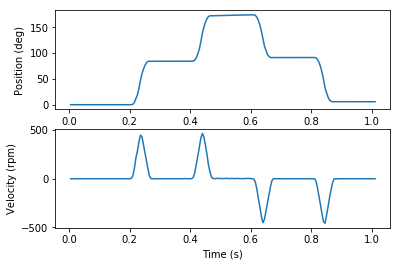

In [20]:
# create a poller and configure it 
poller = il.Poller(servo, n_ch=2)

# set sample period of 5 ms and buffer of 2k samples
poller.configure(t_s=5e-3, sz=2000)
# configure channels to poll position and velocity
poller.ch_configure(ch=0, reg='POS_ACT')
poller.ch_configure(ch=1, reg='VEL_ACT')

# perform homing
servo.mode = il.SERVO_MODE.HOMING
servo.enable()
servo.homing_start()
servo.homing_wait(timeout=5)
servo.disable()

# perform movements
servo.mode = il.SERVO_MODE.PP
servo.enable()
poller.start()

positions = [0, 90, 180, 90, 0]
for position in positions:
    servo.position = position
    servo.wait_reached(timeout=1)

servo.disable()
poller.stop()

# obtain results
t, d, lost = poller.data
if lost:
    print('Data was lost! Increase buffer size or sample time!')

# plot results
plt.figure()
plt.subplot(211)
plt.plot(t, d[0])
plt.xlabel('Time (s)')
plt.ylabel('Position (deg)')

plt.subplot(212)
plt.plot(t, d[1])
plt.xlabel('Time (s)')
plt.ylabel('Velocity (rpm)')

plt.show()

## Monitoring

Monitoring is done on the servo drive side and allows to sample up to 10000 samples/s but, it is single shot, the number of samples is limited and supports up to 4 channels. Furthermore, monitoring offers trigger capabilities. For more details about monitoring capabilities, see this [page](http://doc.ingeniamc.com/display/EMCL/Monitoring). Below you can find an example that captures the rising curve of velocity. This may be useful, for example, to see if the system is properly tuned.

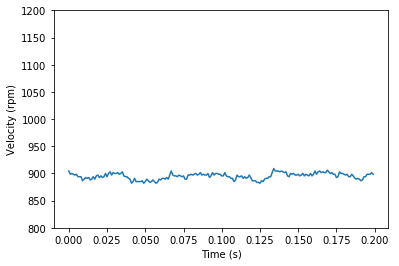

In [21]:
# target velocity (rpm)
VEL_TGT_VAL = 1000

# create monitor and configure it
monitor = il.Monitor(servo)

# set sample period to 1 ms, maximum of 200 samples
monitor.configure(t_s=1e-3, max_samples=200)
# monitor velocity
monitor.ch_configure(ch=0, reg='VEL_ACT')
# configure trigger to 90% of the target velocity
monitor.trigger_configure(il.MONITOR_TRIGGER.POS, source='VEL_ACT',
                          th_pos=VEL_TGT_VAL * 0.9)

# enable servo
servo.mode = il.SERVO_MODE.PV
servo.enable()
monitor.start()

servo.velocity = VEL_TGT_VAL

monitor.wait(timeout=3)
servo.disable()

# plot results
t, d = monitor.data

plt.plot(t, d[0])
plt.xlabel('Time (s)')
plt.ylabel('Velocity (rpm)')
plt.ylim([800, 1200])
plt.show()